In [1]:
# let's get what we need together
from __future__ import division
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from jedi.inference.gradual.typing import ProxyTypingClassValue
%matplotlib inline
import pandas
import scipy.io as sio
import brian2
import os
import copy
import pickle



In [2]:
def current_to_frequency(input_current,population_type,parameters):
    if population_type == 'E':
        a = parameters['a_e']
        b = parameters['b_e']
        d = parameters['d_e']
        return np.divide((a*input_current - b),(1 - np.exp(-d*(a*input_current - b))))
    if population_type == 'PV':
        c_I = parameters['c_I_pv']
        r_0 = parameters['r_0_pv']
        r = np.maximum(c_I*input_current + r_0,0)
        return r
    if population_type == 'SST':
        c_I = parameters['c_I_sst']
        r_0 = parameters['r_0_sst']
        r = np.maximum(c_I*input_current + r_0,0)
        return r
    if population_type == 'VIP':
        c_I = parameters['c_I_vip']
        r_0 = parameters['r_0_vip']
        r = np.maximum(c_I*input_current + r_0,0)
        return r


In [3]:
def dendrite_input_output(exc_current,inh_current,parameters):
    c1 = parameters['c1']
    c2 = parameters['c2']
    c3 = parameters['c3']
    c4 = parameters['c4']
    c5 = parameters['c5']
    c6 = parameters['c6']

    beta = c5*np.exp(-inh_current/c6)

    return c1*(np.tanh((exc_current +c3*inh_current + c4)/beta)) + c2

In [4]:
def NMDA_deriv(S_NMDA_prev,rate_now,parameters):

    return -S_NMDA_prev/parameters['tau_nmda'] + parameters['gamma_nmda']*(1 - S_NMDA_prev)*rate_now

In [5]:
def AMPA_deriv(S_AMPA_prev,rate_now,parameters):

    return -S_AMPA_prev/parameters['tau_ampa'] + parameters['gamma_ampa']*rate_now

In [6]:
def GABA_deriv(S_GABA_prev,rate_now,parameters,cell_section):
    if cell_section == 'soma':
        return -S_GABA_prev/parameters['tau_gaba'] + parameters['gamma_gaba']*rate_now
    elif cell_section == 'dendrite':
        return -S_GABA_prev/parameters['tau_gaba_dend'] + parameters['gamma_gaba']*rate_now

In [7]:
def adaptation_deriv(S_a_prev,rate_now,parameters):
    return -S_a_prev/parameters['tau_adapt'] + rate_now

In [8]:
def sigmoid_DA(height,midpoint,slope):
     return np.exp(slope*(height-midpoint))/(1 + np.exp(slope*(height-midpoint)))


In [9]:
PARAMS = {
    # local connectivity strengths
          # local strengths E-->
          'g_e_self': 0.18 * brian2.nA,
            # 'g_e_cross': 0 * brian2.nA,
          'g_pv_e' : 0.174   * brian2.nA,
          'g_sst_e_self' : 0.0435   * brian2.nA,
            # 'g_sst_e_cross' : 0.0435   * brian2.nA,
          'g_vip_e' : 0.058   * brian2.nA,
          # local strengths PV-->
            'g_e_pv_min': -0.001 * brian2.nA, # dopamine dependent min PV->E strength
          'g_e_pv_max': -0.4 * brian2.nA, # dopamine dependent max PV->E strength #<------------------------
          'g_pv_self': -0.18 * brian2.nA,
          # local strengths SST-->
          'g_e_sst_min': -0.09 * brian2.nA, # dopamine dependent min SST->E strength #<--------------------------
            'g_e_sst_max': -0.11 * brian2.nA, # dopamine dependent max SST->E strength
          'g_pv_sst': -0.17 * brian2.nA,
          'g_vip_sst': -0.1 * brian2.nA,
          # local strengths VIP-->
          'g_sst_vip': -0.05 * brian2.nA,

    # Time constants
          'tau_nmda': 60 * brian2.ms,
          'tau_ampa': 2 * brian2.ms,
          'tau_gaba': 5 * brian2.ms,
          'tau_gaba_dend': 10 * brian2.ms,
          'tau_adapt': 0.1   * brian2.second,

    # synaptic rise constants
          'gamma_nmda': 1.282, # unitless
          'gamma_gaba': 2,
          'gamma_ampa': 5,

    # AMPA/(AMPA+NMDA) fraction
          'ampa_frac_pv': 0.2, # AMPA fraction (1-NMDA fraction) for PV cells
          'ampa_frac': 0.1,    # AMPA fraction (1-NMDA fraction) for all other cell types

    # Min excitatory gradient (spine count) value
          'e_grad_min': 0.45,

    # noise
          'std_noise': 5 * brian2.pA,

    # background inputs
          'I_background_e': 310 * brian2.pA,
          'I_background_i': 300 * brian2.pA,
          'I_background_dend': 30 * brian2.pA,

    # dendrite I/O function parameters
          'c1': 120 * brian2.pA,
          'c2': 136.24 * brian2.pA,
          'c3': 7.0,
          'c4': 0 * brian2.pA,
          'c5': 9.64 * brian2.pA,
          'c6': 20 * brian2.pA,

    # adaptation strengths
          'g_adapt_e': -0.004 * brian2.nA,
          'g_adapt_sst': -0.004 * brian2.nA,
          'g_adapt_vip': -0.004 * brian2.nA,

    # f-I curve parameters - E populations
          'a_e': 0.135 * brian2.Hz / brian2.pA,
          'b_e': 54 * brian2.Hz,
          'd_e': 0.308 * brian2.second,

    # f-I curve parameters - I populations
          'c_I_sst': 132 * brian2.Hz / brian2.nA,
          'c_I_vip': 132 * brian2.Hz / brian2.nA,
          'c_I_pv': 330 * brian2.Hz / brian2.nA,
          'r_0_sst': -33 * brian2.Hz,
          'r_0_vip': -33 * brian2.Hz,
          'r_0_pv': -95 * brian2.Hz,


    # rescale FLN parameter
          'b1': 0.3,

    # Long-range E targets
          'lr_e_self_dend': 0.9,
          'lr_e_cross_dend': 0.1,

    # Long-range I targets
          'lr_pv_e': 0.31,
          'lr_sst_e_self': 0.22 ,
          'lr_vip_e_self': 0.47,

    # Long-range I targets in FEF
        #       'lr_pv_e_fef': 0.2,
        #       'lr_sst_e_self_fef': 0.1 ,
        #       'lr_vip_e_self_fef': 0.7,

    # parameters for D1 occupancy
        #       'slope_d1occ' : 2,
        #       'midpoint_d1occ' : 1,

    # parameters for DA modulation of NMDA
        #       'slope_nmda_da' : 10,
        #       'midpoint_nmda_da' : 0.35,
        #       'g_nmda_da': 0.6,

    # parameters for m current
              'slope_m' : 14,
              'midpoint_m' : 0.85,
              'g_m' : -0.5  * brian2.nA,

    # Long-range connectivity strengths
          # to E cells
          'mu_ee': 1.45,
          # to I cells
          'mu_ie': 2.24,

    # stimulus strength
          'stim_strength': 0.1 * brian2.nA,

    # dopamine release level for the current simulation
        #       'da_rel': 1.5,


    # Simulation parameters
        # initial firing rates
          'r_0_e': 1 * brian2.Hz,
        # timestep
          'dt': 0.5 * brian2.ms,
        # trial length
          'trial_length': 5 * brian2.second,
        # target stimulus on time
          'stim_on': 3 * brian2.second,
        # target stimulus off time
          'stim_off': 3.4 * brian2.second,
        # distractor stimulus on time (if using)
          'distract_on': 2 * brian2.second,
        # distractor stimulus off time (if using)
          'distract_off': 2.4 * brian2.second
}

with open('large_scale_visualWM_DA_params.pck', 'wb') as f:
    pickle.dump(PARAMS, f)

In [10]:
# #NEEDS WORK
#
# lr_targets = np.array([[0,
#                            parameters['lr_e_self_dend'],
#                            parameters['lr_pv_e'],
#                            parameters['lr_sst_e_self'],
#                            parameters['lr_vip_e_self']]]).T * brian2.nA
#
# #FEF???
#                     #soma
# J =  np.array([[parameters['g_e_self'], 0, parameters['g_pv_e'], parameters['g_sst_e_self'],parameters['g_vip_e']],
#                     #dendrite
#                 [0,0,0,0,0],
#                     #pv
#                 [parameters['g_e_pv_max'],0,parameters['g_pv_self'], 0, 0],
#                     #sst
#                 [0,0,parameters['g_pv_sst'], 0,0], #sst to vip removed
#                     #vip
#                 [0,0,0,parameters['g_sst_vip'],0]]).T * brian2.amp
#
#
# print(J.shape)
#
#


In [11]:
# Population structure,
    # XX    =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA

    # Soma
    # Dendrite
    # PV
    # SST
    # VIP


In [12]:
# from scipy.io import loadmat
#
# data = loadmat('anatomical_data/D1R_lyon_regions.mat')
# print(data.keys())

In [13]:
def load_anatomy():
    # Load in anatomical data file
    subgraph_data = sio.loadmat('anatomical_data/beta_bin_hierarchy_subgraph.mat')
    sln = subgraph_data['HierOrderedSLNsubgraph']
    fln = subgraph_data['HierOrderedFLNsubgraph']
    hierarchy = subgraph_data['hierarchy_vals_subgraph']


    temp_list = subgraph_data['subgraph_hierarchical_order']
    area_list_SLN = []
    for row in temp_list:
        v = '%s' % str(row[0][0])
        area_list_SLN.append(v)

    area_column_list  = ['from '+ mystring for mystring in area_list_SLN]
    area_row_list  = ['to '+ mystring for mystring in area_list_SLN]

    df_fln = pandas.DataFrame(fln , columns=area_column_list, index=area_row_list)

    df_sln = pandas.DataFrame(sln , columns=area_column_list, index=area_row_list)

    # # load the receptor data
    # D1R_data = sio.loadmat('anatomical_data/D1R_lyon_regions.mat')
    #
    # D1_density_raw = D1R_data['D1R_lyon_regions_40']

# load the receptor data
    H1TR_data = sio.loadmat('anatomical_data/D1R_lyon_regions.mat')

    H1TR_density_raw = H1TR_data['D1R_lyon_regions_40']


    # load the spine count data
    spine_data = sio.loadmat('anatomical_data/spine_count_lyon_regions.mat')

    spine_count_raw = spine_data['spine_count_lyon_regions_40']

    # df_raw_anatomy = pandas.DataFrame(D1_density_raw, columns=['D1R'], index=area_list_SLN)
    df_raw_anatomy = pandas.DataFrame(H1TR_density_raw, columns=['H1'], index=area_list_SLN)
    # df_raw_anatomy.loc[:, 'H2'] = H1T2_density_raw
    # df_raw_anatomy.loc[:, 'H3'] = H1T3_density_raw
    df_raw_anatomy.loc[:,'spines'] = spine_count_raw
    df_raw_anatomy.loc[:,'hierarchy'] = hierarchy


    return (sln, fln, hierarchy, area_list_SLN,
        df_fln, df_sln, H1TR_density_raw, spine_count_raw, df_raw_anatomy)


In [14]:
def prepare_connectivity(parameters,spine_count_raw,fln,sln,h1tr_density_raw):

    #REPLACE DOPAMINE WITH SEROTONIN
    # d1_occ = sigmoid_DA(parameters['da_rel'],parameters['midpoint_d1occ'],parameters['slope_d1occ'])
    H1T_occ = sigmoid_DA(1,1,1)


    ######## Excitatory gradient ########
    # scale spine count to lie within [0,1] range
    min_spine_count = np.min(spine_count_raw)
    spine_count_rescaled = spine_count_raw-min_spine_count
    spine_grad = spine_count_rescaled/np.max(spine_count_rescaled)

    # define the excitatory gradient to lie according to the spine count
    e_grad_scaling_factor = 1 - parameters['e_grad_min']
    e_grad = parameters['e_grad_min'] + e_grad_scaling_factor*spine_grad

    ######## Local connectivity ########
    # set up the local connectivity matrix
                        #soma
    J =  np.array([[parameters['g_e_self'], 0, parameters['g_pv_e'], parameters['g_sst_e_self'],parameters['g_vip_e']],
                    #dendrite
                [0,0,0,0,0],
                    #pv
                [parameters['g_e_pv_max'],0,parameters['g_pv_self'], 0, 0],
                    #sst
                [0,0,parameters['g_pv_sst'], 0,0], #sst to vip removed
                    #vip
                [0,0,0,parameters['g_sst_vip'],0]]).T * brian2.amp




    pops = ['E1soma','E1dend','PV','SST1','VIP1']
    pops_column_list  = ['from '+ mystring for mystring in pops]
    pops_row_list  = ['to '+ mystring for mystring in pops]

    J_display = J*(1/brian2.pA)
    df_J = pandas.DataFrame(J_display, columns=pops_column_list, index=pops_row_list)
    df_J

    ######### numbers of areas, populations ##########

    num_pops  = J.shape[0]
    num_e_pops = 1
    num_areas = fln.shape[0]

    ######### adaptation ###########
    g_adapt = np.array([[parameters['g_adapt_e'],
                        0,
                        0,
                        parameters['g_adapt_sst'],
                        parameters['g_adapt_vip']]])* brian2.amp


    g_m = np.array([parameters['g_m'],0,0,0,0])* brian2.amp

    ######### AMPA/(AMPA+NMDA) fraction ##########

    ampa_frac = np.array([#soma
                          parameters['ampa_frac'],
                          #dendrite
                          parameters['ampa_frac'],
                          #pv
                          parameters['ampa_frac_pv'],
                          #sst
                          parameters['ampa_frac'],
                          #vip
                          parameters['ampa_frac']])

    nmda_frac = 1 - ampa_frac


    J_nmda = J*((J>0).astype(int))
    J_ampa = J*((J>0).astype(int))
    J_gaba = J*((J<0).astype(int))

    J_gaba_dend =  np.array([#soma
                           [0,
                            #dendrite
                            0,
                            #pv
                            0,
                            #sst
                            parameters['g_e_sst_min'],
                            #vip
                            0]]) * brian2.amp

    ####### LONG-RANGE CONNECTIONS ########
    # Compress FLN
    fln_squish = np.power(fln,parameters['b1'])
    fln_rowtotal = np.sum(fln_squish,axis=1)
    fln_rowtotal_mat = np.matlib.repmat(fln_rowtotal, num_areas,1).T
    fln_squishnorm = fln_squish/fln_rowtotal_mat

    # Isolate long-range connections from superficial layers
    W_superficial = fln_squishnorm*sln
    # Isolate long-range connections from deep layers
    W_deep = fln_squishnorm*(1-sln)


    # This matrix splits the long-range current onto each local population of cells
    lr_targets = np.array([[0,
                           parameters['lr_e_self_dend'],
                           parameters['lr_pv_e'],
                           parameters['lr_sst_e_self'],
                           parameters['lr_vip_e_self']]]).T * brian2.nA

    # This matrix splits the long-range current onto each local population of cells - reflecting greater proportion of CR cells in FEF (Pouget et al., 2009)
    lr_targets_FEF = np.array([[0,
                           parameters['lr_e_self_dend'],
                           parameters['lr_pv_e'],
                           parameters['lr_sst_e_self'],
                           parameters['lr_vip_e_self']]]).T * brian2.nA

    ##### Dopamine modulation #####
    # scale_receptors to lie within [0,1] range
    min_H1TR = np.min(h1tr_density_raw)
    H1TR_rescaled = np.squeeze(h1tr_density_raw)-min_H1TR
    h1t_grad = H1TR_rescaled/np.max(H1TR_rescaled)

    # # strength of excitatory currents through NMDA receptors increases with dopamine (Seamans et al., PNAS, 2001)
    # # To remove effect of dopamine on NMDA, while keeping other dopamine effects, set d1_occ here = 0
    nmda_da_grad = 1
    # + parameters['g_nmda_da']*sigmoid_DA(d1_occ*np.expand_dims(d1_grad,axis=1),parameters['midpoint_nmda_da'],parameters['slope_nmda_da'])
    #
    # # PV-->soma strength decreases with dopamine (Gao et al., J Neurosci, 2003)
    e_pv_da_grad = (parameters['g_e_pv_max'] + np.zeros(num_areas,) - parameters['g_e_pv_max'])/parameters['g_e_pv_min']
    e_pv_da_mat = np.concatenate((np.expand_dims(e_pv_da_grad,axis=1),np.ones((num_areas,num_pops-num_e_pops))),axis=1)
    #
    # # SST-->dendrite strength increases with dopamine (Gao et al., J Neurosci, 2003)
    # # To remove effect of dopamine on PV-->E connections, while keeping other dopamine effects, set d1_occ here = 0
    e_sst_da_grad = (parameters['g_e_sst_min'] + np.zeros(num_areas,) - parameters['g_e_sst_min'])/parameters['g_e_sst_min']
    # e_sst_da_mat = np.concatenate((np.expand_dims(e_sst_da_grad,axis=1),np.expand_dims(e_sst_da_grad,axis=1)),axis=1)
    e_sst_da_mat = (np.expand_dims(e_sst_da_grad,axis=1))
    # # High levels of D1 receptor stimulation engage an outward M-channel, reducing excitability (Arnsten et al., Neurobio. Stress., 2019)
    # # To remove effect of dopamine on the M-channel, while keeping other dopamine effects, set d1_occ here = 0
    # m_da_grad = sigmoid_DA(np.zeros(num_areas,),parameters['midpoint_m'],parameters['slope_m']).reshape(num_areas,)
    m_da_grad = sigmoid_DA(np.zeros(num_areas),parameters['midpoint_m'],parameters['slope_m']).reshape(num_areas,1)


    return(pops, num_pops, num_e_pops, num_areas, e_grad, g_adapt, ampa_frac, nmda_frac, J_nmda, J_ampa,
          J_gaba, J_gaba_dend, W_superficial, W_deep, lr_targets, nmda_da_grad, e_pv_da_mat, e_sst_da_mat, m_da_grad,g_m,lr_targets_FEF)


In [15]:
def initialise_variables(PARAMS,num_areas,num_pops,num_e_pops,area_list_SLN):

    # Initialise
    num_iterations = int(PARAMS['trial_length']/PARAMS['dt'])

    # Choose initial values for rates and synapse variables
    R0 = np.matlib.repmat(np.array([PARAMS['r_0_e'],0,PARAMS['r_0_e'],PARAMS['r_0_e'],PARAMS['r_0_e']]), num_areas, 1) * brian2.Hz
    R = np.zeros((num_iterations,num_areas,num_pops)) * brian2.Hz
    R[0,:,:] = R0

    s_nmda = np.zeros((num_iterations,num_areas,num_pops))
    s_ampa = np.zeros((num_iterations,num_areas,num_pops))
    s_gaba = np.zeros((num_iterations,num_areas,num_pops))
    s_gaba_dend = np.zeros((num_iterations,num_areas,num_pops))
    s_adapt = np.zeros((num_iterations,num_areas,num_pops))

    # # Preassign external inputs
    I_ext    = np.zeros((num_iterations,num_areas,num_pops)) * brian2.amp

    # Let's apply external stimulation to V1 populations E1 & E2
    I_ext[int(PARAMS['stim_on']/PARAMS['dt']):int(PARAMS['stim_off']/PARAMS['dt']),area_list_SLN.index('V1'),pops.index('E1dend')] = PARAMS['stim_strength']

    # No distractor
#     I_ext[int(PARAMS['distract_on']/PARAMS['dt']):int(PARAMS['distract_off']/PARAMS['dt']),area_list_SLN.index('V1'),pops.index('E2dend')] = PARAMS['stim_strength']

    # Create matrices in which we can store the currents
    I_lr_nmda    =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_lr_ampa    =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_local_nmda =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_local_ampa =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_local_gaba =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_soma_dend  =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_total      =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_exc_dend   = np.zeros((num_iterations,num_areas,num_e_pops)) * brian2.pA
    I_inh_dend   = np.zeros((num_iterations,num_areas,num_e_pops)) * brian2.pA
    I_local_gaba_dend =  np.zeros((num_iterations,num_areas,num_e_pops)) * brian2.pA
    I_adapt = np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA

    # Define background inputs
    I_0 = np.zeros((num_areas,num_pops)) * brian2.pA
    I_0[:,[pops.index('E1soma')]] = PARAMS['I_background_e']
    I_0[:,[pops.index('E1dend')]] = PARAMS['I_background_dend']
    I_0[:,[pops.index('PV'),pops.index('SST1'),pops.index('VIP1')]] = PARAMS['I_background_i']

    # Let's set up the noise. We will model the noise as an Ornstein-Uhlenbeck process.
    # Gaussian noise. mean 0, std 1. Dims: timesteps, local populations, areas
    eta = np.random.normal(loc=0.0, scale=1.0, size=(num_iterations,num_areas,num_pops))

    # prepare the right hand side of the above equation
    noise_rhs = eta*((np.sqrt(PARAMS['tau_ampa']*np.power(PARAMS['std_noise'],2))*np.sqrt(PARAMS['dt']))/PARAMS['tau_ampa'])
    noise_rhs[:,:,1] = 0 # remove noise from dendrites
    I_noise = np.zeros((num_areas , num_pops )) *brian2.pA

    return(num_iterations,R,s_nmda,s_ampa,s_gaba,s_gaba_dend,s_adapt
           ,I_ext,I_lr_nmda,I_lr_ampa,I_local_nmda,I_local_ampa,I_local_gaba
           ,I_soma_dend,I_total,I_exc_dend,I_inh_dend,I_local_gaba_dend,I_adapt
           ,I_0,I_noise,noise_rhs)



In [16]:
def large_scale_da_model(pops, num_pops, num_e_pops, num_areas, e_grad, g_adapt, ampa_frac, nmda_frac
                          , J_nmda, J_ampa, J_gaba, J_gaba_dend, W_superficial, W_deep, lr_targets
                          , nmda_da_grad, e_pv_da_mat, e_sst_da_mat, m_da_grad,num_iterations,R,s_nmda
                          ,s_ampa,s_gaba,s_gaba_dend,s_adapt
                          ,I_ext,I_lr_nmda,I_lr_ampa,I_local_nmda,I_local_ampa,I_local_gaba
                          ,I_soma_dend,I_total,I_exc_dend,I_inh_dend,I_local_gaba_dend,I_adapt
                          ,I_0,I_noise,noise_rhs,parameters,lr_targets_FEF):
    for i_t in range(1,num_iterations):

        # update noise - dims = num local pops x num areas
        I_noise = I_noise + -I_noise*(parameters['dt']/parameters['tau_ampa']) + noise_rhs[i_t-1,:,:]

        # Long range NMDA to E populations
        I_lr_nmda[i_t-1,:,:2]   = ((e_grad*parameters['mu_ee']*nmda_da_grad)*W_superficial).dot(s_nmda[i_t-1,:,0:1]).dot(nmda_frac[:2] * (lr_targets[:2,:].T))


        # Long range NMDA to I populations
        I_lr_nmda[i_t-1,:,2:]   = parameters['mu_ie']*e_grad*nmda_da_grad*(W_deep.dot(s_nmda[i_t-1,:,0:1])).dot(nmda_frac[2:]*lr_targets[2:,:].T)


        # Long range AMPA to E populations
        I_lr_nmda[i_t-1,:,:2]   = ((e_grad*parameters['mu_ee']*nmda_da_grad)*W_superficial).dot(s_nmda[i_t-1,:,0:1]).dot(nmda_frac[:2]*lr_targets[:2,:].T)
        # Long range AMPA to I populations
        I_lr_ampa[i_t-1,:,2:]   = parameters['mu_ie']*e_grad*(W_deep.dot(s_ampa[i_t-1,:,0:1])).dot(ampa_frac[2:]*lr_targets[2:,:].T)


        # local NMDA
        I_local_nmda[i_t-1,:,:] = nmda_frac*nmda_da_grad*e_grad*J_nmda.dot(s_nmda[i_t-1,:,:].T).T

        # local AMPA
        I_local_ampa[i_t-1,:,:] = ampa_frac*e_grad*J_ampa.dot(s_ampa[i_t-1,:,:].T).T

        # sum up all the local GABA current onto E and I cell somas
        I_local_gaba[i_t-1,:,:] = e_pv_da_mat*(J_gaba.dot(s_gaba[i_t-1,:,:].T).T)

        # sum up all the local GABA current onto dendrites
        I_local_gaba_dend[i_t-1,:,:] = e_sst_da_mat*(J_gaba_dend.dot(s_gaba_dend[i_t-1,:,:].T).T)
        # I_local_gaba_dend[i_t-1,:,:] = e_sst_da_mat * (s_gaba_dend[i_t-1,:,:] * J_gaba_dend)

        # calculate the dendrite-to-soma current
        I_exc_dend[i_t-1,:,:] = I_local_nmda[i_t-1,:,1:2] + I_lr_nmda[i_t-1,:,1:2] + I_local_ampa[i_t-1,:,1:2] + I_lr_ampa[i_t-1,:,1:2] +I_0[:,1:2] + I_ext[i_t-1,:,1:2] + I_noise[:,1:2]

        I_inh_dend[i_t-1,:,:] = I_local_gaba_dend[i_t-1,:,:]

        I_soma_dend[i_t-1,:,0:1]  = dendrite_input_output(I_exc_dend[i_t-1,:,:],I_inh_dend[i_t-1,:,:],parameters)

        # adaptation current
        I_adapt[i_t-1,:,:] = (g_adapt+0*m_da_grad)*s_adapt[i_t-1,:,:]

        # Define total input current as sum of local NMDA & GABA inputs, with background and external currents,
        # noise and long-range NMDA inputs, and an adaptation current
        I_total[i_t-1,:,:] = I_local_nmda[i_t-1,:,:] + I_local_ampa[i_t-1,:,:] +  I_local_gaba[i_t-1,:,:] + I_0 + I_ext[i_t-1,:,:] + I_noise + I_lr_nmda[i_t-1,:,:] + I_lr_ampa[i_t-1,:,:] + I_soma_dend[i_t-1,:,:] + I_adapt[i_t-1,:,:]


        # Update the firing rates of the excitatory population.
        R[i_t,:,0] = R[i_t-1,:,0] + parameters['dt']*current_to_frequency(I_total[i_t-1,:,0],'E',parameters)/parameters['tau_ampa'] -parameters['dt']*R[i_t-1,:,0]/parameters['tau_ampa']

        # Update the firing rates of the PV population.
        R[i_t,:,2] =  R[i_t-1,:,2] + parameters['dt']*current_to_frequency(I_total[i_t-1,:,2],'PV',parameters)/parameters['tau_ampa'] -parameters['dt']*R[i_t-1,:,2]/parameters['tau_ampa']

        # Update the firing rates of the SST populations.
        R[i_t,:,3] =  R[i_t-1,:,3] + parameters['dt']*current_to_frequency(I_total[i_t-1,:,3],'SST',parameters)/parameters['tau_ampa'] -parameters['dt']*R[i_t-1,:,3]/parameters['tau_ampa']

        # Update the firing rates of the VIP populations.
        R[i_t,:,4] =  R[i_t-1,:,4] +  parameters['dt']*current_to_frequency(I_total[i_t-1,:,4],'VIP',parameters)/parameters['tau_ampa'] -parameters['dt']*R[i_t-1,:,4]/parameters['tau_ampa']

        # Update the NMDA synapses
        s_nmda[i_t,:,0:1] = s_nmda[i_t-1,:,0:1] + parameters['dt']*NMDA_deriv(s_nmda[i_t-1,:,0:1],R[i_t,:,0:1],parameters)

        # Update the AMPA synapses
        s_ampa[i_t,:,0:1] = s_ampa[i_t-1,:,0:1] + parameters['dt']*AMPA_deriv(s_ampa[i_t-1,:,0:1],R[i_t,:,0:1],parameters)

        # Update the GABA synapses onto the somata
        s_gaba[i_t,:,2:] = s_gaba[i_t-1,:,2:] + parameters['dt']*GABA_deriv(s_gaba[i_t-1,:,2:],R[i_t,:,2:],parameters,'soma')

        # Update the GABA synapses onto the dendrites
        s_gaba_dend[i_t,:,2:] = s_gaba_dend[i_t-1,:,2:] + parameters['dt']*GABA_deriv(s_gaba_dend[i_t-1,:,2:],R[i_t,:,2:],parameters,'dendrite')

        # Update the adaptation variable
        s_adapt[i_t,:,:] = s_adapt[i_t-1,:,:] + parameters['dt']*adaptation_deriv(s_adapt[i_t-1,:,:],R[i_t,:,:],parameters)

    return(R)

In [17]:
def plot_all_areas(start_time,end_time,num_areas,area_list_SLN,R,parameters,pops_to_show):
    fig=plt.figure(figsize=(16,90), dpi= 80, facecolor='w', edgecolor='k')
    start_time = 0.5 #seconds
    end_time = 5 #seconds
    plt.rcParams.update({'font.size': 12})

    for i in range(1,num_areas+1):
        ax = plt.subplot(num_areas,2,i)
        ax.set_title(area_list_SLN[i-1])
        # Plot the rates for the E1 soma
        plt.subplots_adjust(hspace = 1)
        if True in (pops == 'E1' for pops in pops_to_show):
            # Plot the rates for the E1 soma
            plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,0],color='r')
        # if True in (pops == 'E2' for pops in pops_to_show):
        #     # Plot the rates for the E2 soma
        #     plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,1],color='b')
        if True in (pops == 'PV' for pops in pops_to_show):
            # Plot the rates for the PV population
            plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,2],color='#1b7837')
        if True in (pops == 'SST1' for pops in pops_to_show):
            # Plot the rates for the SST1 population
            plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,3],color='#b35806')
        # if True in (pops == 'SST2' for pops in pops_to_show):
        #     # Plot the rates for the SST2 population
        #     plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,6],color='#b35806')
        if True in (pops == 'VIP1' for pops in pops_to_show):
            # Plot the rates for the VIP1 population
            plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,4],color='#542788')
        # if True in (pops == 'VIP2' for pops in pops_to_show):
        #     # Plot the rates for the VIP2 population
        #     plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,8],color='#542788')

        # Plot the stimulation time
        plt.plot([parameters['stim_on']-1*brian2.second,parameters['stim_off']-1*brian2.second],[np.max(R[:,i-1,:2]+0.05*np.max(R[:,i-1,:2])),np.max(R[:,i-1,:2]+0.05*np.max(R[:,i-1,:2]))],color='r',linewidth=5.0)

        # Plot the distractor time
        plt.plot([parameters['distract_on']-1*brian2.second,parameters['distract_off']-1*brian2.second],[np.max(R[:,i-1,:2]+0.05*np.max(R[:,i-1,:2])),np.max(R[:,i-1,:2]+0.05*np.max(R[:,i-1,:2]))],color='b',linewidth=5.0)

        # place text above the black line
        axes = plt.gca()
        if i==1:
            axes.text(0.15, 1.2,'External stimulation to', transform=axes.transAxes, fontsize=10, verticalalignment='top')

        plt.legend(pops_to_show)
        plt.xlabel('time (s)')
        plt.ylabel('firing rate (Hz)')
        plt.ylim(0, 40)


    # os.system('say "finished"')



In [18]:
# Run large-scale working memory model

(sln, fln, hierarchy, area_list_SLN,
        df_fln, df_sln, d1_density_raw, spine_count_raw, df_raw_anatomy) = load_anatomy()

(pops, num_pops, num_e_pops, num_areas, e_grad, g_adapt, ampa_frac, nmda_frac
 , J_nmda, J_ampa, J_gaba, J_gaba_dend, W_superficial, W_deep, lr_targets
 , nmda_da_grad, e_pv_da_mat, e_sst_da_mat, m_da_grad,g_m,lr_targets_FEF) = prepare_connectivity(PARAMS,spine_count_raw,fln,sln,d1_density_raw)

(num_iterations,R,s_nmda,s_ampa,s_gaba,s_gaba_dend,s_adapt,I_ext,I_lr_nmda,I_lr_ampa,I_local_nmda,I_local_ampa,I_local_gaba
           ,I_soma_dend,I_total,I_exc_dend,I_inh_dend,I_local_gaba_dend,I_adapt,I_0,I_noise,noise_rhs) = initialise_variables(PARAMS,num_areas,num_pops,num_e_pops,area_list_SLN)

R = large_scale_da_model(pops, num_pops, num_e_pops, num_areas, e_grad, g_adapt, ampa_frac, nmda_frac
                          , J_nmda, J_ampa, J_gaba, J_gaba_dend, W_superficial, W_deep, lr_targets
                          , nmda_da_grad, e_pv_da_mat, e_sst_da_mat, m_da_grad,num_iterations,R,s_nmda
                          ,s_ampa,s_gaba,s_gaba_dend,s_adapt
                          ,I_ext,I_lr_nmda,I_lr_ampa,I_local_nmda,I_local_ampa,I_local_gaba
                          ,I_soma_dend,I_total,I_exc_dend,I_inh_dend,I_local_gaba_dend,I_adapt
                          ,I_0,I_noise,noise_rhs,PARAMS,lr_targets_FEF)


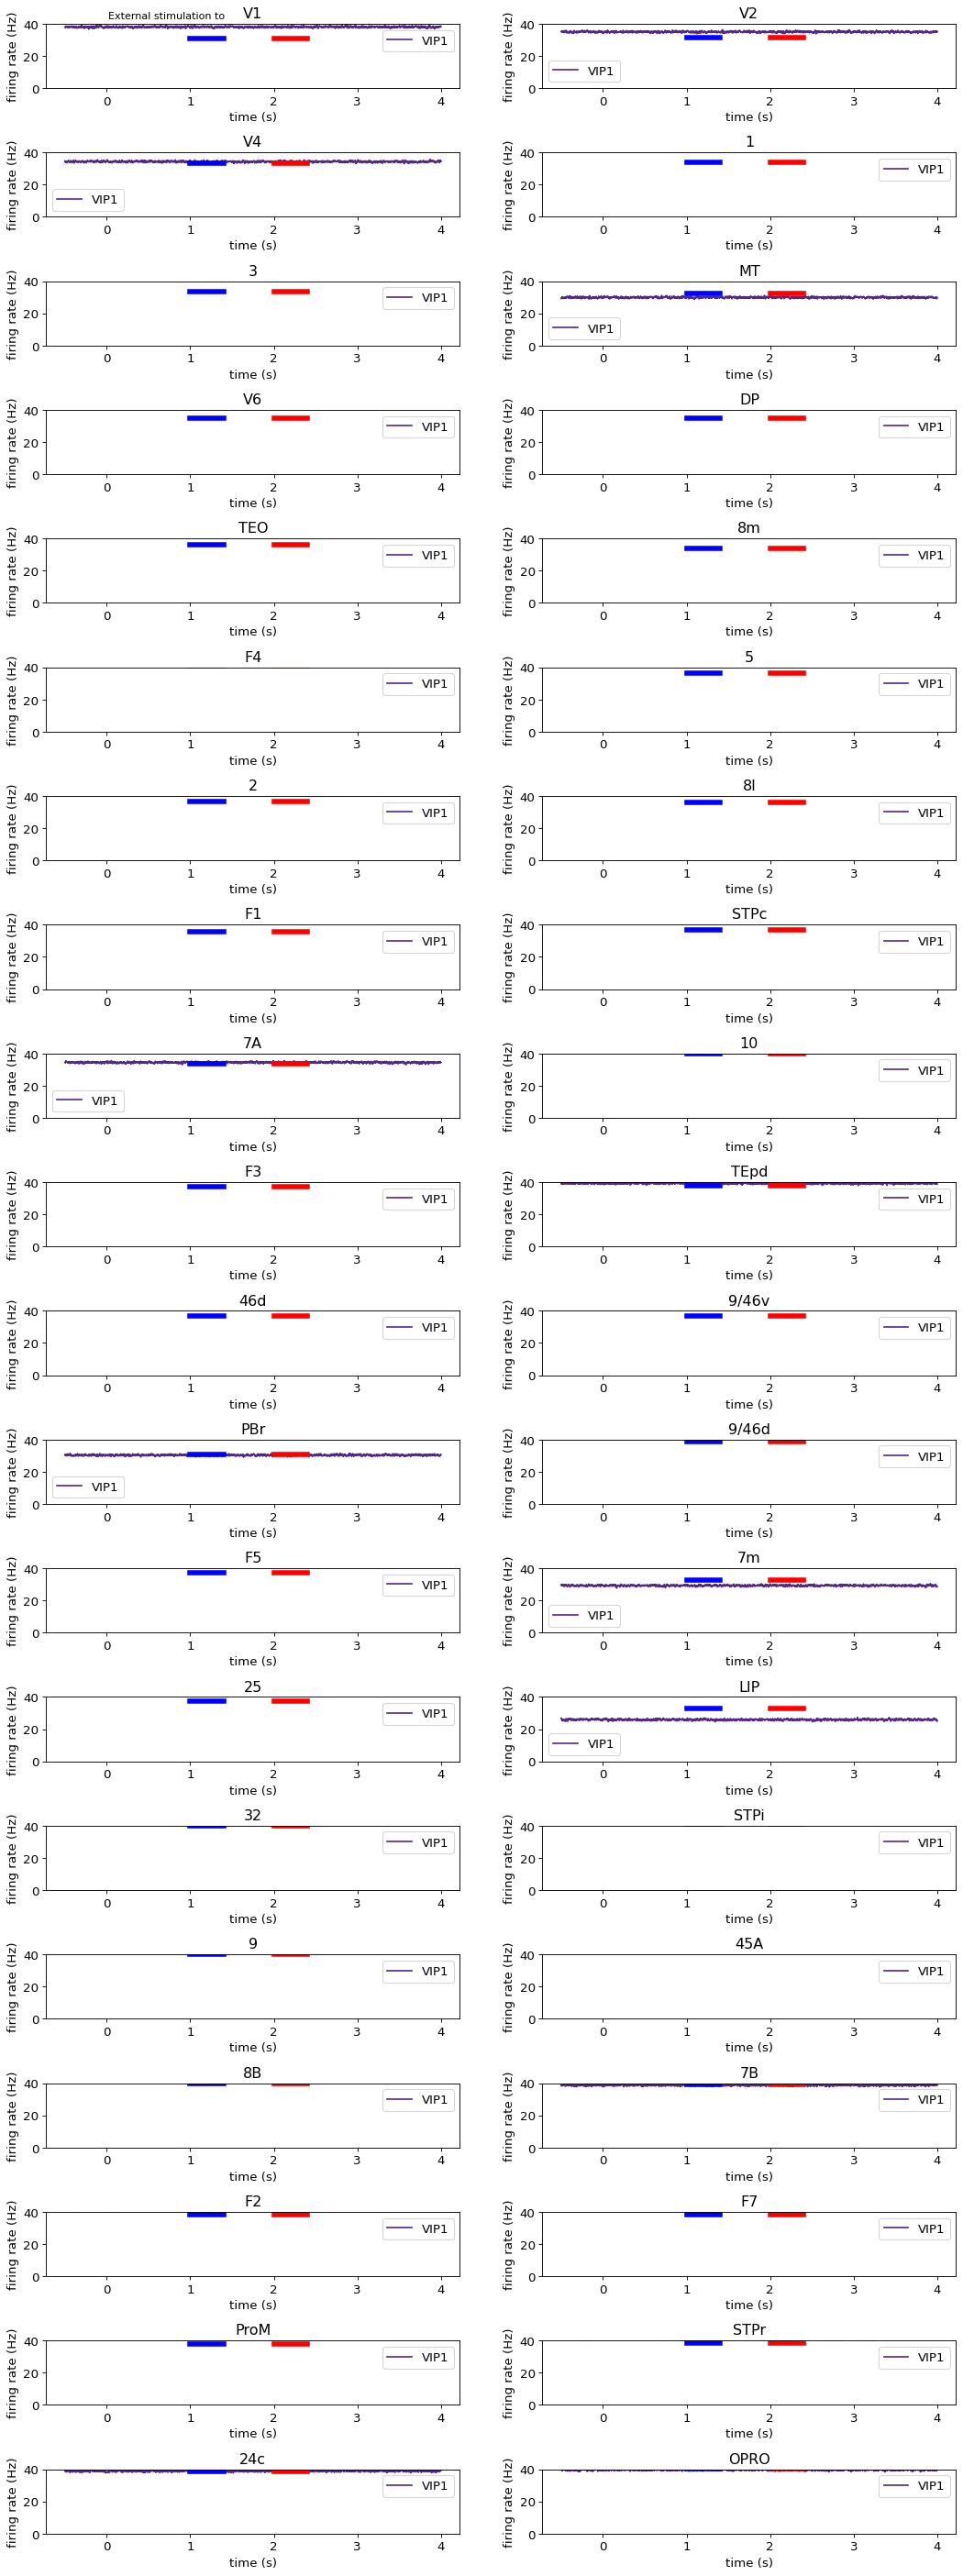

In [20]:
pops_to_plot = ['VIP1']
start_time = 0.5
end_time = 5
plot_all_areas(start_time,end_time,num_areas,area_list_SLN,R,PARAMS,pops_to_plot)